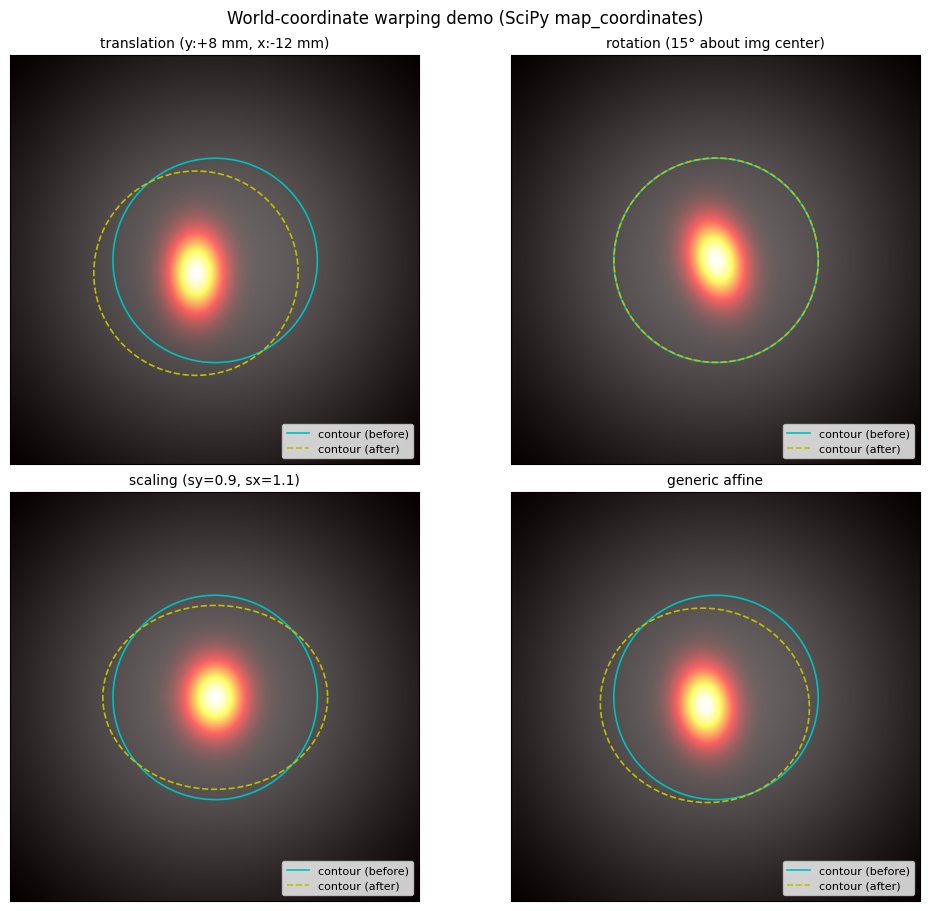

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Self-contained 2D warping demo using world (mm) coordinates + SciPy map_coordinates.

What you get:
- Two coordinate systems (image grid and dose grid) with different spacings.
- A synthetic "dose" image defined in its own CS (Gaussian blob).
- A circle contour in world space.
- A Mapping2D class with forward() and inverse() (translation, rotation about center,
  scaling about center, and generic affine). This fixes the ambiguity that caused
  earlier TypeError/AttributeError issues.
- A robust resampler: destination world -> source world (via inverse mapping) -> source ij -> map_coordinates.
- Four example mappings visualized.

Author: you + ChatGPT
"""

import math
from dataclasses import dataclass
from typing import Tuple, Iterable

import numpy as np
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt


# -----------------------------
# Coordinate system utilities
# -----------------------------
@dataclass
class CoordSystem2D:
    """2D image coordinate system using world units (mm).
    - shape: (H, W) pixels
    - spacing: (sy_mm, sx_mm) mm per pixel (y, x)
    - origin: world coordinate (y_mm, x_mm) at pixel index (0, 0)
    """
    shape: Tuple[int, int]
    spacing: Tuple[float, float] = (1.0, 1.0)
    origin: Tuple[float, float] = (0.0, 0.0)

    @property
    def H(self) -> int: return int(self.shape[0])

    @property
    def W(self) -> int: return int(self.shape[1])

    def ij_to_world(self, ij: np.ndarray) -> np.ndarray:
        """ij: (..., 2) with (i, j). Returns (..., 2) with (y_mm, x_mm)."""
        ij = np.asarray(ij, dtype=np.float64)
        y = self.origin[0] + ij[..., 0] * self.spacing[0]
        x = self.origin[1] + ij[..., 1] * self.spacing[1]
        return np.stack([y, x], axis=-1)

    def world_to_ij(self, yx_mm: np.ndarray) -> np.ndarray:
        """yx_mm: (..., 2) with (y_mm, x_mm). Returns (..., 2) with (i, j)."""
        yx_mm = np.asarray(yx_mm, dtype=np.float64)
        i = (yx_mm[..., 0] - self.origin[0]) / self.spacing[0]
        j = (yx_mm[..., 1] - self.origin[1]) / self.spacing[1]
        return np.stack([i, j], axis=-1)

    def world_grid(self) -> Tuple[np.ndarray, np.ndarray]:
        """Return meshgrid of world coordinates (Y_mm, X_mm) for this CS."""
        ys = self.origin[0] + np.arange(self.H) * self.spacing[0]
        xs = self.origin[1] + np.arange(self.W) * self.spacing[1]
        Y, X = np.meshgrid(ys, xs, indexing='ij')  # (H,W)
        return Y, X

    def center_world(self) -> Tuple[float, float]:
        """World position of the geometric center (fractional pixel center)."""
        c_i = (self.H - 1) / 2.0
        c_j = (self.W - 1) / 2.0
        return tuple(self.ij_to_world(np.array([c_i, c_j])))


# -----------------------------
# Mappings: forward & inverse
# -----------------------------
@dataclass
class Mapping2D:
    """Affine mapping in world coordinates: forward(x) = A @ x + t.
    x is 2-vector (y_mm, x_mm). A is (2,2), t is (2,).
    """
    A: np.ndarray  # (2,2)
    t: np.ndarray  # (2,)

    def forward(self, yx_mm: np.ndarray) -> np.ndarray:
        yx = np.asarray(yx_mm, dtype=np.float64)
        return (yx @ self.A.T) + self.t

    def inverse(self, yx_mm: np.ndarray) -> np.ndarray:
        Ainv = np.linalg.inv(self.A)
        yx = np.asarray(yx_mm, dtype=np.float64)
        return (yx - self.t) @ Ainv.T

    # Constructors
    @staticmethod
    def identity():
        return Mapping2D(A=np.eye(2), t=np.zeros(2))

    @staticmethod
    def from_centered(A_centered: np.ndarray, b_centered: np.ndarray,
                      center_yx: Iterable[float]) -> "Mapping2D":
        """Build a global affine forward(x) = A x + t from a centered form:
           forward(x) = c + A_centered @ (x - c) + b_centered
           => A = A_centered
              t = b_centered + c - A_centered @ c
        """
        c = np.asarray(center_yx, dtype=np.float64)
        A = np.asarray(A_centered, dtype=np.float64)
        b = np.asarray(b_centered, dtype=np.float64)
        t = b + c - A @ c
        return Mapping2D(A=A, t=t)

    @staticmethod
    def translation(dy_mm: float, dx_mm: float) -> "Mapping2D":
        return Mapping2D(A=np.eye(2), t=np.array([dy_mm, dx_mm], dtype=np.float64))

    @staticmethod
    def rotation(deg: float, center_yx: Iterable[float]) -> "Mapping2D":
        th = math.radians(deg)
        R = np.array([[ math.cos(th), -math.sin(th)],
                      [ math.sin(th),  math.cos(th)]], dtype=np.float64)
        return Mapping2D.from_centered(R, np.zeros(2), center_yx)

    @staticmethod
    def scaling(sy: float, sx: float, center_yx: Iterable[float]) -> "Mapping2D":
        S = np.array([[sy, 0.0],
                      [0.0, sx]], dtype=np.float64)
        return Mapping2D.from_centered(S, np.zeros(2), center_yx)

    @staticmethod
    def generic_affine(A: np.ndarray, b: np.ndarray, center_yx: Iterable[float]) -> "Mapping2D":
        """A is 2x2, b is 2, both in world mm. Affine about 'center' like rotation/scaling."""
        return Mapping2D.from_centered(np.asarray(A, dtype=np.float64),
                                       np.asarray(b, dtype=np.float64),
                                       center_yx)


# -----------------------------
# Synthetic data generators
# -----------------------------
def make_gaussian_on_cs(cs: CoordSystem2D,
                        center_world: Tuple[float, float],
                        sigma_mm: Tuple[float, float] = (12.0, 18.0),
                        amplitude: float = 1.0) -> np.ndarray:
    """2D anisotropic Gaussian defined in world space, sampled on 'cs'."""
    Yw, Xw = cs.world_grid()  # (H,W)
    cy, cx = float(center_world[0]), float(center_world[1])
    sy, sx = float(sigma_mm[0]), float(sigma_mm[1])
    val = amplitude * np.exp(-0.5 * (((Yw - cy) / sy)**2 + ((Xw - cx) / sx)**2))
    return val.astype(np.float32)


def make_circle_contour(center_world: Tuple[float, float],
                        radius_mm: float,
                        step_mm: float = 0.5) -> np.ndarray:
    """Return Nx2 (y_mm, x_mm) points roughly spaced by step_mm along a circle."""
    circumference = 2.0 * math.pi * radius_mm
    n = max(16, int(round(circumference / max(step_mm, 1e-6))))
    ts = np.linspace(0, 2 * math.pi, n, endpoint=False)
    y = center_world[0] + radius_mm * np.sin(ts)
    x = center_world[1] + radius_mm * np.cos(ts)
    return np.stack([y, x], axis=-1).astype(np.float64)  # (N,2)


def deform_points_world(points_yx: np.ndarray, mapping: Mapping2D) -> np.ndarray:
    """Apply forward mapping to a set of world-space points (N,2)."""
    return mapping.forward(points_yx)


# -----------------------------
# Resampling (SciPy)
# -----------------------------
def resample_by_mapping(source: np.ndarray,
                        src_cs: CoordSystem2D,
                        dst_cs: CoordSystem2D,
                        mapping: Mapping2D,
                        mode: str = "linear",
                        cval: float = 0.0) -> np.ndarray:
    """
    Pullback resampling:
      For each dst pixel at world position x_dst,
      find x_src = mapping.inverse(x_dst),
      then sample 'source' at src_ij = world_to_ij(x_src).

    mode: 'nearest' | 'linear' | 'cubic' (orders 0, 1, 3)
    """
    order = {"nearest": 0, "linear": 1, "cubic": 3}[mode]

    # Destination world grid
    Yd, Xd = dst_cs.world_grid()  # (Hd, Wd)
    Hd, Wd = Yd.shape

    # Flatten to list of world coordinates (N,2)
    dst_world = np.stack([Yd.ravel(), Xd.ravel()], axis=-1)  # (N,2)

    # Map to source world coords via inverse
    src_world = mapping.inverse(dst_world)  # (N,2)

    # Convert to source ij (float), then to coords for map_coordinates
    src_ij = src_cs.world_to_ij(src_world)  # (N,2) with (i, j)
    coords = np.stack([src_ij[:, 0], src_ij[:, 1]], axis=0)  # (2, N)

    # Sample
    sampled = map_coordinates(source, coords, order=order, mode='constant', cval=cval)
    return sampled.reshape(Hd, Wd).astype(np.float32)


# -----------------------------
# Visualization helpers
# -----------------------------
def plot_one(ax,
             background: np.ndarray,
             overlay: np.ndarray,
             bg_title: str,
             cs: CoordSystem2D,
             contour_before_world: np.ndarray = None,
             contour_after_world: np.ndarray = None,
             vmin: float = 0.0,
             vmax: float = 1.0):
    ax.imshow(background, cmap='gray', origin='upper', vmin=np.min(background), vmax=np.max(background))
    im = ax.imshow(overlay, cmap='hot', origin='upper', alpha=0.6, vmin=vmin, vmax=vmax)

    # Convert contours from world to pixel for plotting
    if contour_before_world is not None:
        ij = cs.world_to_ij(contour_before_world)
        ax.plot(ij[:, 1], ij[:, 0], 'c-', lw=1.2, label='contour (before)')
    if contour_after_world is not None:
        ij2 = cs.world_to_ij(contour_after_world)
        ax.plot(ij2[:, 1], ij2[:, 0], 'y--', lw=1.2, label='contour (after)')

    ax.set_title(bg_title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])
    if contour_before_world is not None or contour_after_world is not None:
        ax.legend(loc='lower right', fontsize=8, frameon=True)
    return im


# -----------------------------
# Demo
# -----------------------------
def main():
    # 1) Define two coordinate systems (different spacings to show resampling works)
    img_cs  = CoordSystem2D(shape=(256, 256), spacing=(1.0, 1.0), origin=( -128.0, -128.0))
    dose_cs = CoordSystem2D(shape=(192, 192), spacing=(1.5, 1.2), origin=( -144.0, -115.2))

    # 2) Create a synthetic background "image" and a "dose" in its own CS
    #    Background: mildly varying field so you can see overlay
    Yg, Xg = img_cs.world_grid()
    background = 0.25 + 0.75 * np.exp(-0.5 * ((Yg / 100.0)**2 + (Xg / 100.0)**2)).astype(np.float32)

    # Dose: Gaussian in its own CS
    dose_center_world = (0.0, 0.0)
    dose = make_gaussian_on_cs(dose_cs, dose_center_world, sigma_mm=(18.0, 12.0), amplitude=1.0)

    # 3) A circle contour in world space (e.g., ROI)
    contour = make_circle_contour(center_world=(0.0, 0.0), radius_mm=min(img_cs.H, img_cs.W) * 0.25, step_mm=1.0)

    # 4) Define mappings (forward). Resampling uses inverse internally.
    c_img = img_cs.center_world()
    maps = {
        "translation (y:+8 mm, x:-12 mm)": Mapping2D.translation(dy_mm=+8.0, dx_mm=-12.0),
        "rotation (15° about img center)":   Mapping2D.rotation(deg=15.0, center_yx=c_img),
        "scaling (sy=0.9, sx=1.1)":          Mapping2D.scaling(sy=0.90, sx=1.10, center_yx=c_img),
        "generic affine":                    Mapping2D.generic_affine(
                                                A=np.array([[0.95, -0.05],
                                                            [0.08,  1.02]], dtype=np.float64),
                                                b=np.array([5.0, -7.0], dtype=np.float64),
                                                center_yx=c_img)
    }

    # 5) Render
    ncols = 2
    nrows = math.ceil(len(maps) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 9), constrained_layout=True)
    axes = np.array(axes).reshape(-1)

    vmax_overlay = float(np.max(dose))  # same scale across panels

    for ax, (name, M) in zip(axes, maps.items()):
        # Warp the dose from dose_cs -> img_cs using inverse mapping (pullback)
        warped = resample_by_mapping(dose, dose_cs, img_cs, M, mode="linear", cval=0.0)

        # Deform contour for visualization using FORWARD mapping
        contour_def = deform_points_world(contour, M)

        plot_one(ax, background, warped, name, img_cs,
                 contour_before_world=contour,
                 contour_after_world=contour_def,
                 vmin=0.0, vmax=vmax_overlay)

    # Hide any unused axes
    for k in range(len(maps), len(axes)):
        axes[k].axis('off')

    fig.suptitle("World-coordinate warping demo (SciPy map_coordinates)", fontsize=12)
    plt.show()


if __name__ == "__main__":
    main()
